In [1]:

# Импортируем библиотеки
import mne
import numpy as np
import pandas as pd
import pickle
from zipfile import ZipFile

# графические библиотеки
from matplotlib import pyplot as plt

%matplotlib widget
import os


# графические библиотеки
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# библиотеки машинного обучения
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# отображать по умолчанию длину дата Датафрейма
pd.set_option("display.max_rows", 9, "display.max_columns", 9)

# библиотека взаимодействия с интерпретатором
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
import os

# Hide output
from IPython.display import clear_output

In [2]:
# Установка версий программных пакетов
#!pip install -qr ../requirements.txt

In [14]:
# Библиотека вызова функций, специально разработанных для данного ноутбука
sys.path.insert(1, '../')

from utils.functions import config_reader
from utils.figures import get_all_sensors_plot 

# import constants from the config
config = config_reader('../config/data_config.json') 

# path for data
PATH = config.PATH

# path for models
PATH_FOR_MODEL = config.PATH_FOR_MODEL

In [4]:
# Папка для сохранения весов лучшей модели при обучении (исп-ся в ModelCheckpoint в функции callbacks)
#PATH_TEMP_MODEL = '/models/temp_best_model'

# if not os.path.exists(PATH_TEMP_MODEL):
#     os.mkdir(PATH_TEMP_MODEL)    

if not os.path.exists(PATH_FOR_MODEL):
    os.mkdir(PATH_FOR_MODEL) 
    
#from utils.models_utils import f1, callbacks, reset_random_seeds
#from utils import figures 

# Импортируем модели
#from models.models import ModelSimpleRNN, ModelLSTM

In [5]:
import random

# Fix seed
seed_value = config.seed_value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 1. Установим начальное значение для генератора случайных чисел в Python
random.seed(seed_value)

# 2. Установим начальное значение для генератора случайных чисел в Numpy
np.random.seed(seed_value)

# 3. Установим начальное значение для генератора случайных чисел в tensorflow 
#tf.random.set_seed(seed_value)


Задача: мультиклассовая классификация “распознавания жестов”.  
Построить классификационную модель, которая по показаниям от датчиков будет определять жест, выполненный пользователем протеза во время записи данных, что отражено в значении целевой переменной.

* X_train.npy - обучающая выборка имеющая размерности "наблюдения, датчики, время"
* X_test.npy - тестоваая выборка имеющая размерности "наблюдения, датчики, время"
* y_train.npy - целевая переменная для обучающей выборки, которая содержит следующие классы:

| Номер <br> класса | Описание |
| :---: | :--- |
| "0"  |  жест "open" |
| "1"  |  сгиб мизинца |
| "2"  |  сгиб безымянного пальца |
| "3"  |  сгиб среднего пальца |
| "4"  |  сгиб жеста "пистолет" |
| "5"  |  сгиб указательного пальца |
| "6"  |  сгиб большого пальца |
| "7"  |  жест "ok" |
| "8"  |  жест "grab" |


In [6]:
# библиотеки машинного обучения
#import tensorflow as tf
#from tensorflow import keras
#from keras import backend as K
#from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
#from keras import layers

In [7]:
# Создадим словарь для агрегации данных. Импортируем его структуру (ключи и названия файлов в архиве) из конфига
# Поскольку ключи словаря в конфиге могут находиться только в строковом формате (str),
# то для удобства переведём их в целочисленный (int)

# mounts = dict() #config.mounts.toDict()

# for i in mounts.keys():
#     mounts[int(i)] = mounts.pop(i)
# mounts.keys()

In [8]:
with ZipFile('../data/test_task.zip') as myzip:
    for file in myzip.namelist():
        if file[-3:] == 'npy':
            print(file)

X_test.npy
X_train.npy


In [9]:
# read files 
with ZipFile('../data/test_task.zip') as myzip:
    
    y_train = pd.read_csv(myzip.open('y_train.csv'))
    sample_submission = pd.read_csv(myzip.open('sample_submission.csv'))
    
    X_train = np.load(myzip.open('X_train.npy'))
    X_test = np.load(myzip.open('X_test.npy'))
       
        
print(X_train.shape, X_test.shape)
print(y_train.shape )

(323, 40, 100) (54, 40, 100)
(32300, 2)


In [10]:
print(f"Размерность файла 'X_train': {X_train.shape}. Размерность: наблюдения, датчики, время")
print(f"Размерность файла 'y_train': {y_train.shape}. Размерность: наблюдения, время")

Размерность файла 'X_train': (323, 40, 100). Размерность: наблюдения, датчики, время
Размерность файла 'y_train': (32300, 2). Размерность: наблюдения, время


In [16]:
get_all_sensors_plot(5, X_train) #plot_counter=1

In [11]:
y_train[['sample_id', 'timestep']] = y_train['sample-timestep'].str.split('-', 1, expand=True).astype(int)
y_train = y_train.pivot(index='sample_id', columns='timestep', values='class')
y_train_index = y_train.index
y_train = y_train.sort_index() # на всякий случай
y_train = y_train.values

print(y_train.shape)

(323, 100)


In [12]:
y_train 

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 6, 6, 6],
       ...,
       [0, 0, 0, ..., 7, 7, 7],
       [7, 7, 7, ..., 0, 0, 0],
       [0, 0, 0, ..., 4, 4, 4]], dtype=int64)

Файл y_train содержит классы переменной

In [36]:
df_y_train = []
for idx, arr in zip(y_train_index, y_train):
    
    series = pd.Series(arr)
    series.index = [f"{idx}-{i}" for i in series.index]
    df_y_train.append(series)
    
df_y_train = pd.concat(df_y_train)
df_y_train = df_y_train.reset_index()
df_y_train.columns = ["sample-timestep", "class"]
df_y_train

,sample-timestep,class
0,0-0,0
1,0-1,0
2,0-2,0
3,0-3,0
...,...,...
32296,322-96,4
32297,322-97,4
32298,322-98,4
32299,322-99,4


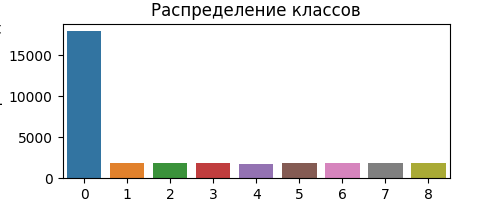

In [86]:
# построим график распределения команд 
y_counts = df_y_train['class'].value_counts()

fig, ax = plt.subplots(figsize=(5, 2)) 
fig = sns.barplot(data = df_y_train, x = y_counts.index, y = y_counts)
fig.set_title('Распределение классов')
fig.set_xlabel('Класс')
fig.set_ylabel('Количество экземпляров в каждой команде');

## data preprocessing

In [18]:
X_train.shape

(323, 40, 100)

In [54]:
def data_preproc(df_data):
    "Функция преобразования выборки: разница показателей всех датчиков за"
    "первую и вторую половину времени активности по каждому объекту"
    
    sens_cols = []
    for i in range(df_data.shape[1]):
        sens_cols.append('sensor_' + str(i))

    
    df_feated = pd.DataFrame(columns=sens_cols)
    for i in range(df_data.shape[0]):
        sensors = pd.DataFrame(data=df_data[i], index=range(40), columns=range(100)).T
        df_feated.loc[i, sens_cols] = (sensors.iloc[50:].mean() - sensors.iloc[:80].mean()).values.reshape(-1) 
    
    return df_feated

In [56]:
X_train_preproc = data_preproc(X_train)
X_train_preproc.shape

(323, 40)

In [57]:
X_train_preproc

,sensor_0,sensor_1,sensor_2,sensor_3,...,sensor_36,sensor_37,sensor_38,sensor_39
0,-37.045,-0.6575,-28.955,-0.335,...,-3.9275,0.425,4.165,-0.095
1,-18.8225,-0.55,-22.3225,-2.23,...,-4.5675,-1.0625,-26.8475,0.015
2,33.85,0.265,88.275,-0.0825,...,-0.205,0.705,93.6125,0.615
3,-144.1425,0.425,-131.7575,9.7175,...,24.015,0.205,-94.305,-0.0525
...,...,...,...,...,...,...,...,...,...
319,-315.8625,0.165,-534.0125,-10.8,...,189.895,-1.64,-225.67,-0.9375
320,135.23,-0.2775,17.185,4.4775,...,-67.1275,0.1425,78.2075,0.38
321,52.4125,0.9325,221.6125,-0.445,...,89.0275,2.2575,-97.6175,-0.49
322,239.39,0.575,280.695,7.2575,...,-151.6175,-0.09,0.6,1.455


In [58]:
X_test_preproc = data_preproc(X_test)
X_test_preproc.shape

(54, 40)

In [23]:
y_train.shape

(323, 100)

# Model training

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, GradientBoostingRegressor, StackingClassifier


In [39]:
def stratified_cross_valid(model: LogisticRegression, 
                           X_train: pd.DataFrame, y_train: pd.Series, 
                           n: int, metric: str) -> None:
    """
    Функция оценки модели на кросс-валидации: вывод графика с результатами 
    кросс-валидации, кривой достаточности данных и таблицы с результатами
    """
    print(model)
    cv_splitter = StratifiedKFold(n_splits = n)
    
    metric_table = pd.DataFrame()

    i = 0
                    
    cv_res = cross_validate(
        model, 
        X_train, 
        y_train, 
        scoring = metric, 
        n_jobs = -1, 
        cv = cv_splitter, 
        return_train_score = True, 
        verbose = 0)

    cv_train = cv_res['train_score'].mean()
    cv_test = cv_res['test_score'].mean()


    metric_table.loc[i, 'cv_train'] = cv_train
    metric_table.loc[i, 'cv_test'] = cv_test

                    
    metric_table['cv_dif'] = metric_table['cv_train'] - metric_table['cv_test']

    #результаты кросс-валидации
    fig = sns.pointplot(x=np.arange(n), y=cv_res['train_score'], color = 'r')
    fig = sns.pointplot(x=np.arange(n), y=cv_res['test_score'], color = 'g')
    fig.set_title('Результаты кросс-валидации', fontsize=16)
    fig.set_xlabel('Порядковый номер части совокупности')
    fig.set_ylabel('Показатель качества модели\n f-score')
    #plot.set_ylim(0.4, 1.1)
    fig.grid() # показать сетку
    plt.show()

    # кривая обучения
    result = []

    s = len(X_train)
    p = len(X_train) // (n + 1)
    for i in np.arange(p, s - p + 1, p):
        model.fit(X_train.iloc[:i], y_train.iloc[:i].values.ravel())  # + .values.ravel()
        predict = model.predict(X_train.iloc[i:i+p])
        res = f1_score(y_train.iloc[i:i+p], predict, average='macro')
        result.append(res)

    fig = sns.pointplot(x=np.arange(p, s - p + 1, p), y=result)
    fig.set_title('Кривая обучения', fontsize=16)
    fig.set_xlabel('Количество объектов для обучения')
    fig.set_ylabel('Показатель качества  модели\n f-score')
    fig.set_ylim(0.4, 1.05)
    fig.grid() # показать сетку
    plt.show()
    print ()
    
    print(metric_table.sort_values(by ='cv_test'))
    print ()

In [74]:
df_y_train['class']

0        0
1        0
2        0
3        0
        ..
32296    4
32297    4
32298    4
32299    4
Name: class, Length: 32300, dtype: int64

In [75]:
cv_splitter = StratifiedKFold(n_splits = n)

metric_table = pd.DataFrame()

i = 0

solver='saga'                                               # 'liblinear' 'saga' 'newton-cg'
C=1                                                         #  1, 10, 100, 500
n=6
model = LogisticRegression(solver=solver, random_state=0, C=C)
        
cv_res = cross_validate(
    model, 
    X_train_preproc, 
    df_y_train['class'], 
    
    n_jobs = -1, 
    cv = cv_splitter, 
    return_train_score = True, 
    verbose = 0)

ValueError: Found input variables with inconsistent numbers of samples: [323, 32300]

In [60]:

solver='saga'                                               # 'liblinear' 'saga' 'newton-cg'
C=1                                                         #  1, 10, 100, 500
n=6
cl = LogisticRegression(solver=solver, random_state=0, C=C)
stratified_cross_valid(cl, X_train_preproc, X_test_preproc, n, 'f1_macro') 
cv_splitter = StratifiedKFold(n_splits = n)
display(cv_splitter)

LogisticRegression(C=1, random_state=0, solver='saga')


ValueError: Found input variables with inconsistent numbers of samples: [323, 54]

In [61]:
cl = LogisticRegression(solver=solver, penalty='l2', random_state=42, C=1)
cl.fit(X_train_preproc, df_y_train['class'].values) #y_train.values.ravel()
sub_predict = cl.predict(X_test_preproc)

ValueError: Found input variables with inconsistent numbers of samples: [323, 32300]

In [64]:
rf = RandomForestClassifier(
    n_estimators=110, 
    min_samples_leaf=5,
    max_depth=7,
    #verbose=1, 
    n_jobs=-1, 
    random_state= seed_value)

#Train model
rf.fit(X_train_prepoc, y_train)

# Prediction
y_pred = rf.predict(X_test_preproc)
y_pred

#print(classification_report(y_test, y_pred))

#get_ROC_plot(rf, X_test, y_test, 'Random Forest CL')

array([[4, 4, 4, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 7, 7, 7],
       [7, 7, 7, ..., 0, 0, 0],
       [0, 0, 0, ..., 4, 4, 4]], dtype=int64)

In [68]:
y_pred[3]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], dtype=int64)